In [1]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.neural_network import MLPRegressor
from keras.models import Sequential
from keras.layers import Dense
from sklearn.ensemble import GradientBoostingClassifier
from interpret.glassbox import ExplainableBoostingRegressor
from interpret import show
from sklearn.tree import plot_tree
import plotly.graph_objs as go

In [2]:
def function(t, B, C):
  return B*np.log(1+(t)/C)

def plot_function(B, C):
	t = np.array([i for i in range(0, 900)])
	plt.plot(t, function(t, B, C))


def percent_difference(x, y):
  return abs(x[1:] - y[1:]) / y[1:] * 100

def plot_prediction_real(y, y_pred, coef):

  scatter = go.Scatter(x=y, y=y_pred, mode='markers', name='', marker=dict(size=5))

  x = np.linspace(min(y), max(y), 100)

  curve1 = go.Scatter(x=x, y=1.3*x, mode='lines', name='y = 1.3x', line=dict(color='red'))
  curve2 = go.Scatter(x=x, y=0.7*x, mode='lines', name='y = 0.7x', line=dict(color='blue'))

  fig = go.Figure(data=[scatter, curve1, curve2])
  fig.update_layout(title=f'Prédiction de {coef} en fonction la valeur réelle', xaxis_title='y_true', yaxis_title='y_pred')

  fig.show()


def plot_prediction(test_indices, y, y_pred):
    
    rows = len(y_pred) // 6 + 1
    fig, axs = plt.subplots(nrows=rows, ncols=6, figsize=(30, rows*40 / 9))
    t = np.array([i for i in range(0, 900)])


    for i, (true, pred) in enumerate(zip(y, y_pred)):
        row = i // 6
        col = i % 6

        ax = axs[row, col]
        ax.set_title(f'Prévisions pour l\'élément {test_indices[i]}')
        ax.plot(t, function(t, *true), label='y_true')
        ax.plot(t, function(t, *pred), label='y_predicted')

        diff = percent_difference(function(t, *true), function(t, *pred))
        if (diff[100:] > 30).any():
          title_color = 'red'
          ax.title.set_color('red')
          y_high = function(t, *(np.array(true) * 1.3))
          ax.plot(t, y_high, label='y_high')
          y_low = function(t, *(np.array(true) * 0.7))
          ax.plot(t, y_low, label='y_low')

        ax.legend()

    plt.tight_layout()
    plt.show()


In [3]:
def readCSV(version2 = False):
  X = pd.read_csv("./X.csv") if version2 == False else pd.read_csv("./X_2.csv")
  y = pd.read_csv("./y.csv")
  return X, y

In [4]:
def getRandomData(test_size, version2 = False):
	X, y = readCSV(version2)
	X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
	return X_train, X_test, y_train, y_test 

In [5]:
def getData(version2 = False):
	X, y = readCSV(version2)
	X_train, X_test, y_train, y_test = X, X, y, y
	return X_train, X_test, y_train, y_test 

In [6]:
def run_custom_functions(model, name):
  if (name == "Explainable Boosting"):
    show(model.explain_global())
  elif (name == "Decision Tree"):
    fig, ax = plt.subplots(figsize=(34, 34))
    plot_tree(model, ax=ax, feature_names=X_test.columns[:-1].tolist(), filled=True)
    plt.show()

In [7]:
def benchmark(models, X, y):
  models_pred = []
  for name, model in models:

    all_pred = []

    for i in range (X.shape[0]):
      pred = []
      
      for coeff in ["B", "C"]:
        model.fit(X.drop("ID", axis=1).drop(i), y[coeff].drop(i))
        
        y_pred = model.predict(X.drop("ID", axis=1).loc[[i]])
        y_pred = np.clip(y_pred, 0.00001, None)
        pred.append(y_pred)

      all_pred.append(pred)
    models_pred.append(all_pred)
    
  return models_pred

## Entrainement sur toutes les données et test sur toutes les données (avec B et C entrainés séparéments)

In [8]:
X, y = readCSV(True)

models = [
    ('Random Forest', RandomForestRegressor(n_estimators=10000, max_depth=1000000)),
    ('Gradient Boosting ', GradientBoostingRegressor()),
    # ('Explainable Boosting', ExplainableBoostingRegressor()),
]

models_pred = benchmark(models, X, y)

In [68]:
def displayFunctionValues(data_pred):
  days = 700
  new_list = [[x[0][0], x[1][0]] for x in data_pred]

  functions_values = [function(days, pred[0], pred[1]) for pred in new_list]

  predictions_list = [[row[0], row[1]] for row in y.to_records(index=False)]
  predictions_true = [function(days, pred[0], pred[1]) for pred in predictions_list]

  plt.scatter([prediction for prediction in predictions_true], [point for point in functions_values], color='red', label='A')
  x_values = np.linspace(0, max(predictions_true), 100)

  plt.plot(x_values, 0.7*x_values, color='green', label='0.7*x')
  plt.plot(x_values, 1.3*x_values, color='orange', label='1.3*x')

  abs = [prediction for prediction in predictions_true]
  ord = [point for point in functions_values]

  count = 0
  for i in range(len(abs)):
    count += 1 if (abs[i] * 0.7 <= ord[i] and abs[i] * 1.3 >= ord[i]) else 0

  print(count / len(abs))

  plt.show()

In [ ]:
variable_importance sur le model plot


In [29]:
def mean_squared_error(models_pred, days):
  new_list = [[x[0][0], x[1][0]] for x in models_pred]

  functions_values = np.array([function(days, pred[0], pred[1]) for pred in new_list])

  predictions_list = [[row[0], row[1]] for row in y.to_records(index=False)]
  predictions_true = np.array([function(days, pred[0], pred[1]) for pred in predictions_list])
  return (np.sqrt(np.mean((functions_values - predictions_true)**2)))

In [40]:
def mean_squared_error_2(models_pred, days):
  new_list = [[x[0][0], x[1][0]] for x in models_pred]

  functions_values = np.array([function(days, pred[0], pred[1]) for pred in new_list])

  predictions_list = [[row[0], row[1]] for row in y.to_records(index=False)]
  predictions_true = np.array([function(days, pred[0], pred[1]) for pred in predictions_list])
  return np.mean((functions_values / predictions_true)**2)

In [88]:
def display_mean_squarred_error(models_pred):
  days = np.linspace(50, 4 * 365, 100)
  value = [mean_squared_error_2(models_pred, day) for day in days]
  plt.plot(days, value)
  plt.show()


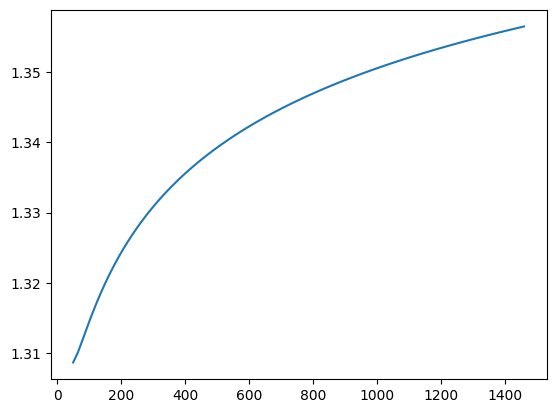

In [57]:
display_mean_squarred_error(models_pred[0])

0.6153846153846154


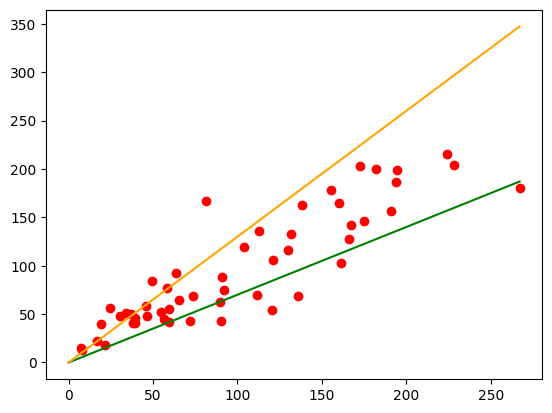

In [69]:
displayFunctionValues(models_pred[0])

0.6153846153846154


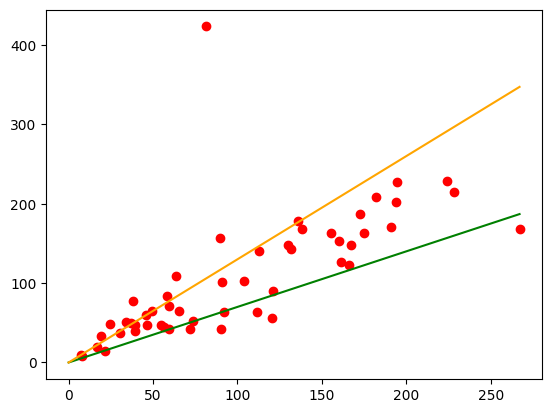

In [70]:
displayFunctionValues(models_pred[1])

In [90]:
X, y = readCSV()
models_pred = benchmark(models, X, y)

0.6153846153846154


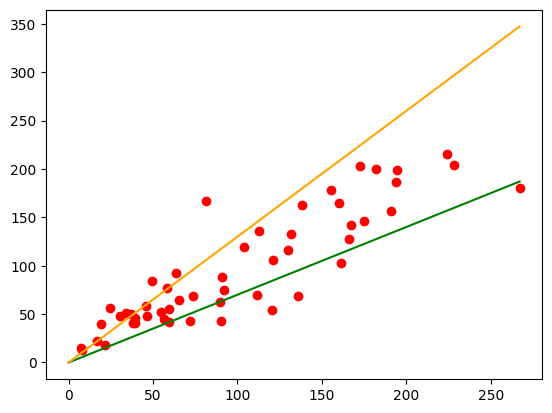

In [71]:
displayFunctionValues(models_pred[0])

0.6153846153846154


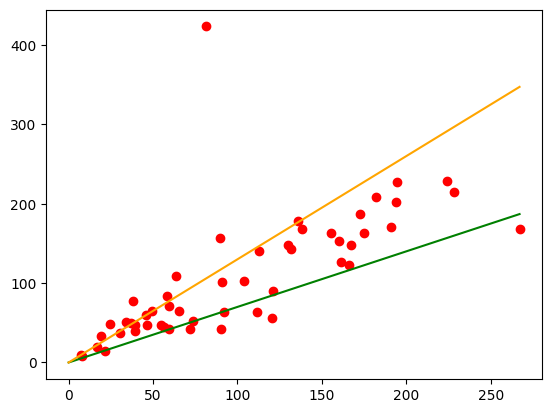

In [74]:
displayFunctionValues(models_pred[1])

In [75]:
X_new = X

In [81]:
X_new["t_15"] = [function(15, pred[0], pred[1]) for pred in y.values.tolist()]

In [82]:
X_new.head()

,CT_tPrime,M_wToBinder,M_silicaFume,CT_sigma_new,ID,Type_x_CN,Type_x_CR,Type_x_CS,Type_y_basic,CT_tPrime_squared,CT_tPrime_sqrt,CT_tPrime_log,CT_sigma_new_squared,CT_sigma_new_sqrt,CT_sigma_new_log,t_15
0,1.000000,0.126483,0.0,0.848359,1136,1,0,0,1,1.000000,1.000000,9.999995e-07,0.719712,0.921064,-1.644506e-01,4.626655
1,1.000000,0.126483,0.0,1.000000,1137,1,0,0,1,1.000000,1.000000,9.999995e-07,1.000000,1.000000,9.999995e-07,3.110860
2,1.000000,0.126483,0.0,0.993934,1138,1,0,0,1,1.000000,1.000000,9.999995e-07,0.987905,0.996963,-6.083116e-03,1.992682
3,1.000000,0.126483,0.0,0.793768,1139,1,0,0,1,1.000000,1.000000,9.999995e-07,0.630067,0.890936,-2.309630e-01,5.534971
4,0.074074,0.332272,0.0,0.984773,1176,0,0,1,1,0.005487,0.272166,-2.602676e+00,0.969778,0.992357,-1.534320e-02,20.787293


In [83]:
models_pred_2 = benchmark(models, X_new, y)

0.8076923076923077


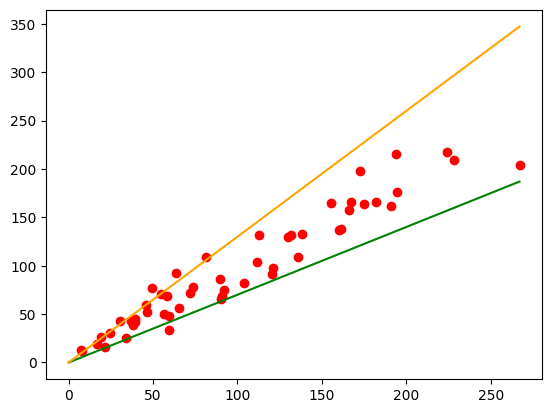

In [85]:
displayFunctionValues(models_pred_2[0])

0.7884615384615384


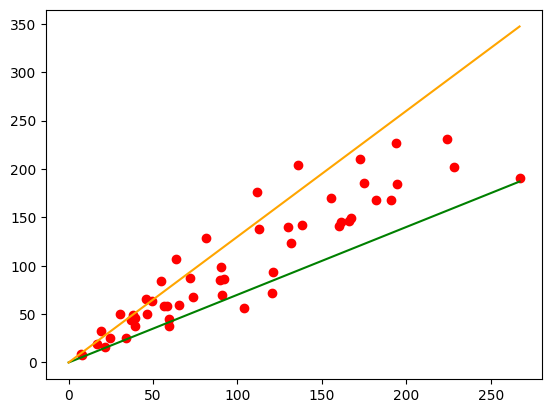

In [86]:
displayFunctionValues(models_pred_2[1])

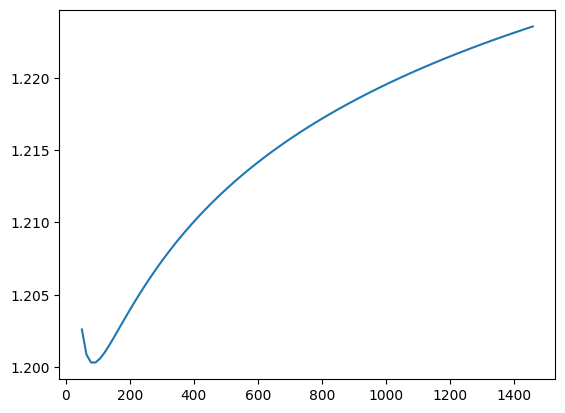

In [90]:
display_mean_squarred_error(models_pred_2[1])